## Swahili MMLU Benchmark: Evaluating Gemma-3n Models On Swahili MMLU

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

In [2]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps --upgrade transformers # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [3]:
import gc
from unsloth import FastModel
import torch
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directories for results
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Helper Functions

In [4]:
def load_model_and_tokenizer(model_id, is_unsloth=False):
    """Load model with appropriate method"""
    if is_unsloth:
        model, processor = FastModel.from_pretrained(
            model_name=model_id,
            dtype=None,
            max_seq_length=2048,
            load_in_4bit=False,
        )

        # Extract the tokenizer from the processor
        tokenizer = processor.tokenizer
        print(f"Extracted tokenizer of type: {type(tokenizer).__name__}")

        # Ensure we have pad token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer
    else:
        print(f"Loading {model_id} in full precision")
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            trust_remote_code=True,
        )
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            trust_remote_code=True,
        )

        # Ensure we have pad token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer

def format_example(question, options, answer=None, include_answer=True):
    """Format a single example in MMLU style"""
    prompt = question
    for i, opt in enumerate(options):
        prompt += f"\n{['A', 'B', 'C', 'D'][i]}. {opt}"
    prompt += "\nJibu:"  # "Answer:" in Swahili
    if include_answer and answer:
        prompt += f" {answer}\n\n"
    return prompt

def create_few_shot_prompt(train_examples, test_question, test_options, k=5):
    """Create few-shot prompt with k examples"""
    # Start with instruction
    prompt = "Jibu maswali yafuatayo ya kuchagua jibu sahihi:\n\n"

    # Add k examples
    for i in range(min(k, len(train_examples))):
        example = train_examples[i]
        prompt += format_example(
            example['question'],
            example['options'],
            example['answer'],
            include_answer=True
        )

    # Add test question without answer
    prompt += format_example(test_question, test_options, include_answer=False)

    return prompt

def sample_diverse_examples(examples, n_samples=500, seed=42):
    """Sample examples ensuring diversity across subjects"""
    import random
    random.seed(seed)
    np.random.seed(seed)

    # Group examples by subject
    subject_examples = defaultdict(list)
    for ex in examples:
        subj = ex.get('subject', 'unknown')
        subject_examples[subj].append(ex)

    # Calculate how many examples to take from each subject
    n_subjects = len(subject_examples)
    samples_per_subject = max(1, n_samples // n_subjects)

    sampled = []
    remaining_quota = n_samples

    # First pass: take up to samples_per_subject from each subject
    for subj, exs in subject_examples.items():
        n_to_take = min(len(exs), samples_per_subject, remaining_quota)
        if n_to_take > 0:
            sampled.extend(random.sample(exs, n_to_take))
            remaining_quota -= n_to_take

    # Second pass: if we still need more samples, take from subjects with remaining examples
    if remaining_quota > 0:
        all_remaining = []
        for subj, exs in subject_examples.items():
            already_taken = sum(1 for s in sampled if s.get('subject') == subj)
            remaining = exs[already_taken:]
            all_remaining.extend(remaining)

        if all_remaining:
            additional = random.sample(all_remaining, min(remaining_quota, len(all_remaining)))
            sampled.extend(additional)

    # Shuffle the final sample
    random.shuffle(sampled)

    # Print sampling statistics
    sample_subjects = defaultdict(int)
    for ex in sampled:
        sample_subjects[ex.get('subject', 'unknown')] += 1

    print(f"\nSampled {len(sampled)} examples from {len(sample_subjects)} subjects")
    print("Sample distribution (top 10 subjects):")
    for subj, count in sorted(sample_subjects.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {subj}: {count} examples")

    return sampled

@torch.no_grad()
def evaluate_with_logits(model, tokenizer, test_data, train_data, k_shot=5, verbose=True, sample_size=None, seed=42):
    """Evaluate using logit-based approach like MMLU"""
    model.eval()

    # Sample test data if requested
    if sample_size and sample_size < len(test_data):
        print(f"\nSampling {sample_size} examples from {len(test_data)} total examples...")
        test_data = sample_diverse_examples(test_data, n_samples=sample_size, seed=seed)

    # Get token IDs for choices
    choice_ids = []
    for choice in ["A", "B", "C", "D"]:
        tokens = tokenizer.encode(choice, add_special_tokens=False)
        if tokens:
            choice_ids.append(tokens[-1])
        else:
            # Try with space before
            tokens = tokenizer.encode(f" {choice}", add_special_tokens=False)
            if tokens:
                choice_ids.append(tokens[-1])
            else:
                choice_ids.append(None)

    if verbose:
        print(f"Choice token IDs: {choice_ids}")

    correct = 0
    predictions = []

    total = len(test_data)
    for idx, test_example in enumerate(test_data):
        # Create few-shot prompt
        prompt = create_few_shot_prompt(
            train_data,
            test_example['question'],
            test_example['options'],
            k=k_shot
        )

        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048)
        input_ids = inputs.input_ids.to(model.device)

        # Get logits
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0, -1]  # Last token logits

        # Get probabilities for A, B, C, D tokens
        choice_logits = []
        for i, choice_id in enumerate(choice_ids[:len(test_example['options'])]):
            if choice_id is not None:
                choice_logits.append(logits[choice_id].item())
            else:
                choice_logits.append(-1000.0)

        # Convert to probabilities
        choice_logits = torch.tensor(choice_logits)
        probs = torch.nn.functional.softmax(choice_logits, dim=0).cpu().numpy()

        # Get prediction
        pred_idx = np.argmax(probs)
        pred = ["A", "B", "C", "D"][pred_idx]

        # Check if correct
        is_correct = pred == test_example['answer']
        correct += int(is_correct)

        predictions.append({
            'idx': idx,
            'predicted': pred,
            'correct': test_example['answer'],
            'is_correct': is_correct,
            'probs': probs.tolist(),
            'subject': test_example.get('subject', 'unknown')  # Use subject instead of category
        })

        if verbose and (idx + 1) % 50 == 0:
            print(f"Progress: {idx+1}/{total} - Running accuracy: {correct/(idx+1)*100:.1f}%")

    accuracy = correct / len(test_data)
    return accuracy, predictions

In [5]:
# Load full dataset
print("Loading Swahili MMLU dataset...")
dataset = load_dataset("Svngoku/swahili-mmmlu", split="train")
print(f"Total examples: {len(dataset)}")

# Analyze subjects (not categories)
subjects = defaultdict(int)
for example in dataset:
    subj = example.get('subject', 'unknown')
    subjects[subj] += 1

print(f"\nFound {len(subjects)} subjects:")
# Sort subjects by count
sorted_subjects = sorted(subjects.items(), key=lambda x: x[1], reverse=True)
for subj, count in sorted_subjects[:20]:  # Show top 20 subjects
    print(f"  {subj}: {count} examples")

if len(subjects) > 20:
    print(f"  ... and {len(subjects) - 20} more subjects")

# Create train/test split (use first 5 per subject for few-shot, rest for test)
few_shot_examples = []
test_examples = []

for subject in subjects:
    subj_examples = [ex for ex in dataset if ex.get('subject', 'unknown') == subject]
    if len(subj_examples) > 5:
        few_shot_examples.extend(subj_examples[:5])
        test_examples.extend(subj_examples[5:])
    else:
        # If less than 5 examples, use all for test and sample from other subjects for few-shot
        test_examples.extend(subj_examples)

# If we don't have enough few-shot examples, sample from the dataset
if len(few_shot_examples) < 5:
    # Sample from subjects with more than 5 examples
    for subject in subjects:
        if subjects[subject] > 5:
            subj_examples = [ex for ex in dataset if ex.get('subject', 'unknown') == subject]
            few_shot_examples.extend(subj_examples[:5])
            if len(few_shot_examples) >= 5:
                break

print(f"\nDataset split:")
print(f"  Few-shot examples: {len(few_shot_examples)}")
print(f"  Test examples: {len(test_examples)}")

Loading Swahili MMLU dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Total examples: 14042

Found 57 subjects:
  professional_law: 1534 examples
  moral_scenarios: 895 examples
  miscellaneous: 783 examples
  professional_psychology: 612 examples
  high_school_psychology: 545 examples
  high_school_macroeconomics: 390 examples
  elementary_mathematics: 378 examples
  moral_disputes: 346 examples
  prehistory: 324 examples
  philosophy: 311 examples
  high_school_biology: 310 examples
  nutrition: 306 examples
  professional_accounting: 282 examples
  professional_medicine: 272 examples
  high_school_mathematics: 270 examples
  clinical_knowledge: 265 examples
  security_studies_test-sw-KE.csv: 245 examples
  high_school_microeconomics: 238 examples
  high_school_world_history: 237 examples
  conceptual_physics: 235 examples
  ... and 37 more subjects

Dataset split:
  Few-shot examples: 285
  Test examples: 13757


In [6]:
# Define models with proper naming
MODEL_CONFIG = {
    "gemma-3n-swahili-E2B-it": {
        "id": "Nadhari/gemma-3n-swahili-E2B-it",
        "is_unsloth": False
    },
    "gemma-3n-swahili-E4B-it": {
        "id": "Nadhari/gemma-3n-swahili-E4B-it",
        "is_unsloth": False
    },
    "gemma-3n-E2B-it": {
        "id": "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
        "is_unsloth": True
    },
    "gemma-3n-E4B-it": {
        "id": "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
        "is_unsloth": True
    },
}

# Run evaluation for each model
all_results = {}

for model_name, config in MODEL_CONFIG.items():
    print(f"\n{'='*70}")
    print(f"🔄 Evaluating: {model_name}")
    print(f"   Model ID: {config['id']}")
    print(f"   Type: {'Unsloth' if config['is_unsloth'] else 'HuggingFace'}")
    print(f"{'='*70}")

    try:
        # Load model
        start_time = datetime.now()
        model, tokenizer = load_model_and_tokenizer(
            config['id'],
            is_unsloth=config['is_unsloth']
        )

        # Run evaluation
        print(f"\nStarting evaluation on 500 sampled examples...")
        accuracy, predictions = evaluate_with_logits(
            model,
            tokenizer,
            test_examples,
            few_shot_examples,
            k_shot=5,
            verbose=True,
            sample_size=500,  # Add this line to sample 500 examples
            seed=42          # Add this line for reproducibility
        )

        end_time = datetime.now()
        eval_time = (end_time - start_time).total_seconds()

        # Calculate subject-wise accuracy
        subject_results = defaultdict(lambda: {'correct': 0, 'total': 0})

        for pred in predictions:
            subj = pred['subject']
            subject_results[subj]['total'] += 1
            if pred['is_correct']:
                subject_results[subj]['correct'] += 1

        # Calculate accuracies
        subject_accuracies = {}
        for subj, stats in subject_results.items():
            if stats['total'] > 0:
                subject_accuracies[subj] = stats['correct'] / stats['total']
            else:
                subject_accuracies[subj] = 0.0

        # Store results
        results = {
            'model_name': model_name,
            'model_id': config['id'],
            'overall_accuracy': accuracy,
            'subject_accuracies': subject_accuracies,
            'subject_counts': {subj: stats['total'] for subj, stats in subject_results.items()},
            'total_examples': len(test_examples),
            'correct_predictions': int(accuracy * len(test_examples)),
            'evaluation_time_seconds': eval_time,
            'timestamp': datetime.now().isoformat(),
            'predictions': predictions[:100]  # Store first 100 predictions for analysis
        }

        all_results[model_name] = results

        # Save individual model results
        result_file = f"results/{model_name}_results.json"
        with open(result_file, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        print(f"\n✅ {model_name} Evaluation Complete!")
        print(f"   Overall Accuracy: {accuracy*100:.2f}%")
        print(f"   Evaluation Time: {eval_time:.1f} seconds")
        print(f"   Results saved to: {result_file}")

        # Show top 5 best and worst subjects
        sorted_subjects = sorted(subject_accuracies.items(), key=lambda x: x[1], reverse=True)
        print(f"\n   Top 5 subjects:")
        for subj, acc in sorted_subjects[:5]:
            count = subject_results[subj]['total']
            print(f"     {subj}: {acc*100:.1f}% ({count} examples)")

        print(f"\n   Bottom 5 subjects:")
        for subj, acc in sorted_subjects[-5:]:
            count = subject_results[subj]['total']
            print(f"     {subj}: {acc*100:.1f}% ({count} examples)")

        # Cleanup
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# Save combined results
with open('results/all_models_results.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print("\n✅ All evaluations complete!")


🔄 Evaluating: gemma-3n-swahili-E2B-it
   Model ID: Nadhari/gemma-3n-swahili-E2B-it
   Type: HuggingFace
Loading Nadhari/gemma-3n-swahili-E2B-it in full precision


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]


Starting evaluation on 500 sampled examples...

Sampling 500 examples from 13757 total examples...

Sampled 500 examples from 57 subjects
Sample distribution (top 10 subjects):
  clinical_knowledge: 11 examples
  miscellaneous: 11 examples
  high_school_psychology: 11 examples
  professional_law: 11 examples
  moral_scenarios: 11 examples
  high_school_macroeconomics: 11 examples
  high_school_microeconomics: 10 examples
  high_school_us_history: 10 examples
  human_aging: 10 examples
  high_school_geography: 10 examples
Choice token IDs: [236776, 236799, 236780, 236796]
Progress: 50/500 - Running accuracy: 34.0%
Progress: 100/500 - Running accuracy: 32.0%
Progress: 150/500 - Running accuracy: 30.0%
Progress: 200/500 - Running accuracy: 30.5%
Progress: 250/500 - Running accuracy: 28.0%
Progress: 300/500 - Running accuracy: 27.7%
Progress: 350/500 - Running accuracy: 27.7%
Progress: 400/500 - Running accuracy: 27.0%
Progress: 450/500 - Running accuracy: 27.8%
Progress: 500/500 - Runnin

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]


Starting evaluation on 500 sampled examples...

Sampling 500 examples from 13757 total examples...

Sampled 500 examples from 57 subjects
Sample distribution (top 10 subjects):
  clinical_knowledge: 11 examples
  miscellaneous: 11 examples
  high_school_psychology: 11 examples
  professional_law: 11 examples
  moral_scenarios: 11 examples
  high_school_macroeconomics: 11 examples
  high_school_microeconomics: 10 examples
  high_school_us_history: 10 examples
  human_aging: 10 examples
  high_school_geography: 10 examples
Choice token IDs: [236776, 236799, 236780, 236796]
Progress: 50/500 - Running accuracy: 30.0%
Progress: 100/500 - Running accuracy: 28.0%
Progress: 150/500 - Running accuracy: 29.3%
Progress: 200/500 - Running accuracy: 30.5%
Progress: 250/500 - Running accuracy: 31.2%
Progress: 300/500 - Running accuracy: 30.7%
Progress: 350/500 - Running accuracy: 29.7%
Progress: 400/500 - Running accuracy: 28.7%
Progress: 450/500 - Running accuracy: 27.8%
Progress: 500/500 - Runnin

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Extracted tokenizer of type: GemmaTokenizerFast

Starting evaluation on 500 sampled examples...

Sampling 500 examples from 13757 total examples...

Sampled 500 examples from 57 subjects
Sample distribution (top 10 subjects):
  clinical_knowledge: 11 examples
  miscellaneous: 11 examples
  high_school_psychology: 11 examples
  professional_law: 11 examples
  moral_scenarios: 11 examples
  high_school_macroeconomics: 11 examples
  high_school_microeconomics: 10 examples
  high_school_us_history: 10 examples
  human_aging: 10 examples
  high_school_geography: 10 examples
Choice token IDs: [236776, 236799, 236780, 236796]
Progress: 50/500 - Running accuracy: 24.0%
Progress: 100/500 - Running accuracy: 24.0%
Progress: 150/500 - Running accuracy: 29.3%
Progress: 200/500 - Running accuracy: 30.0%
Progress: 250/500 - Running accuracy: 30.0%
Progress: 300/500 - Running accuracy: 29.3%
Progress: 350/500 - Running accuracy: 29.7%
Progress: 400/500 - Running accuracy: 28.7%
Progress: 450/500 - Ru

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Extracted tokenizer of type: GemmaTokenizerFast

Starting evaluation on 500 sampled examples...

Sampling 500 examples from 13757 total examples...

Sampled 500 examples from 57 subjects
Sample distribution (top 10 subjects):
  clinical_knowledge: 11 examples
  miscellaneous: 11 examples
  high_school_psychology: 11 examples
  professional_law: 11 examples
  moral_scenarios: 11 examples
  high_school_macroeconomics: 11 examples
  high_school_microeconomics: 10 examples
  high_school_us_history: 10 examples
  human_aging: 10 examples
  high_school_geography: 10 examples
Choice token IDs: [236776, 236799, 236780, 236796]
Progress: 50/500 - Running accuracy: 22.0%
Progress: 100/500 - Running accuracy: 22.0%
Progress: 150/500 - Running accuracy: 26.7%
Progress: 200/500 - Running accuracy: 28.0%
Progress: 250/500 - Running accuracy: 28.0%
Progress: 300/500 - Running accuracy: 28.3%
Progress: 350/500 - Running accuracy: 27.4%
Progress: 400/500 - Running accuracy: 26.8%
Progress: 450/500 - Ru

## Visualizations

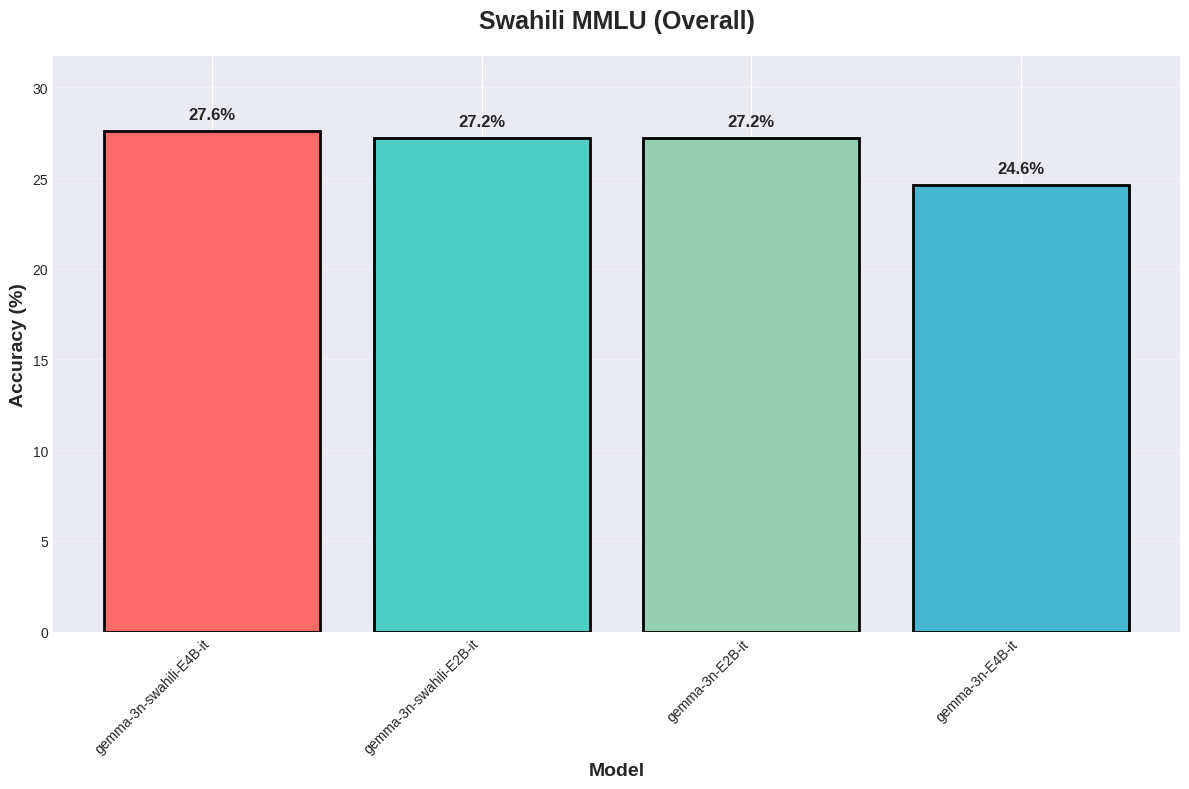

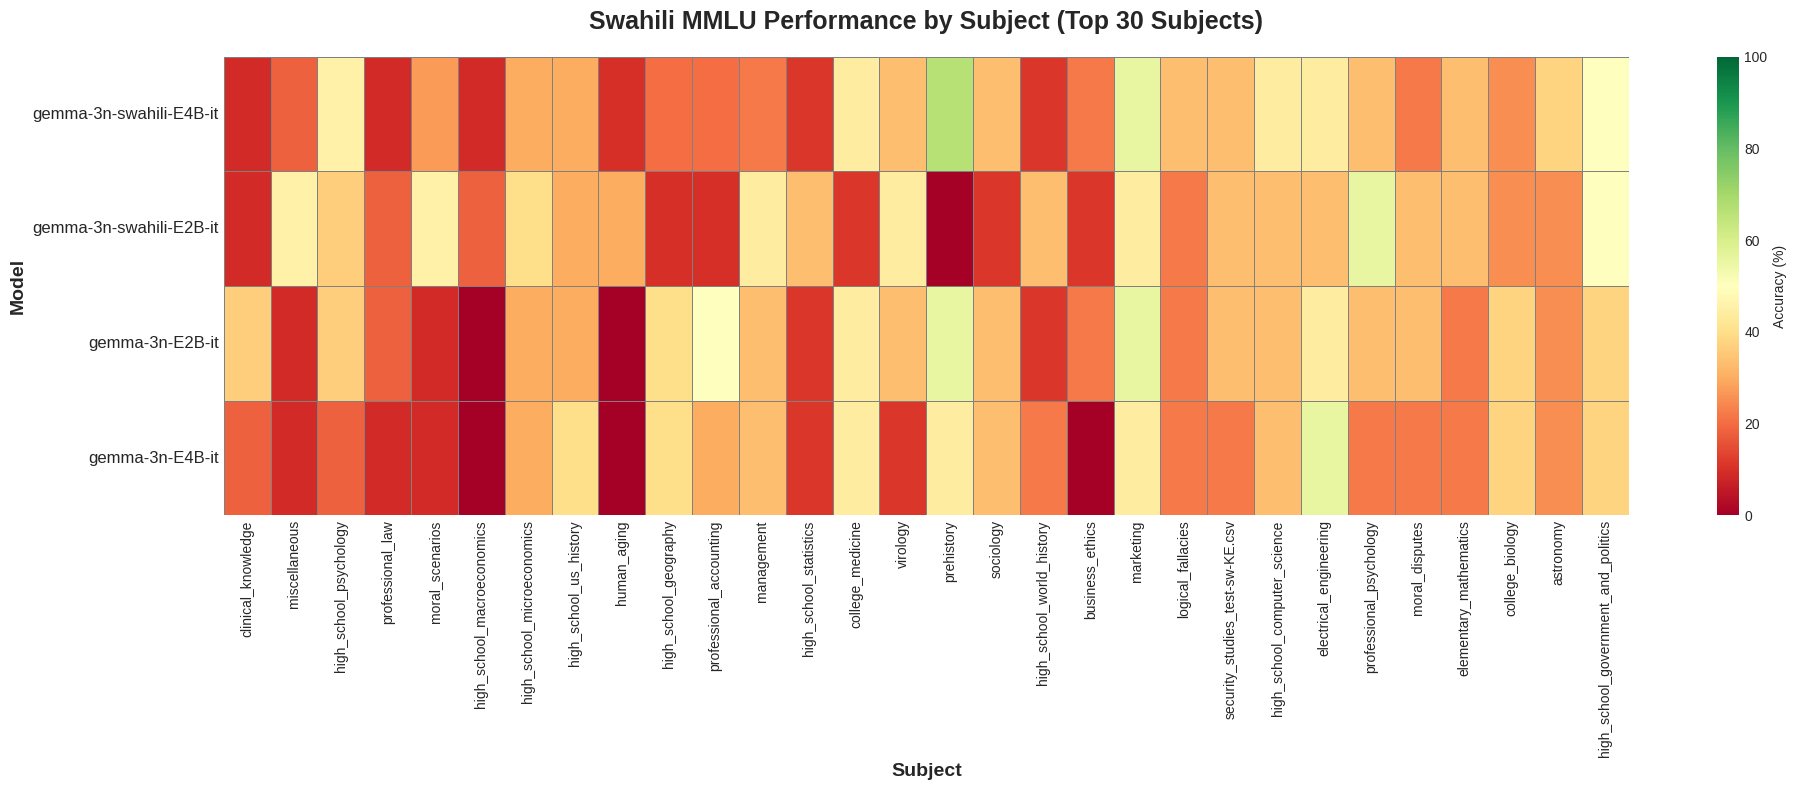

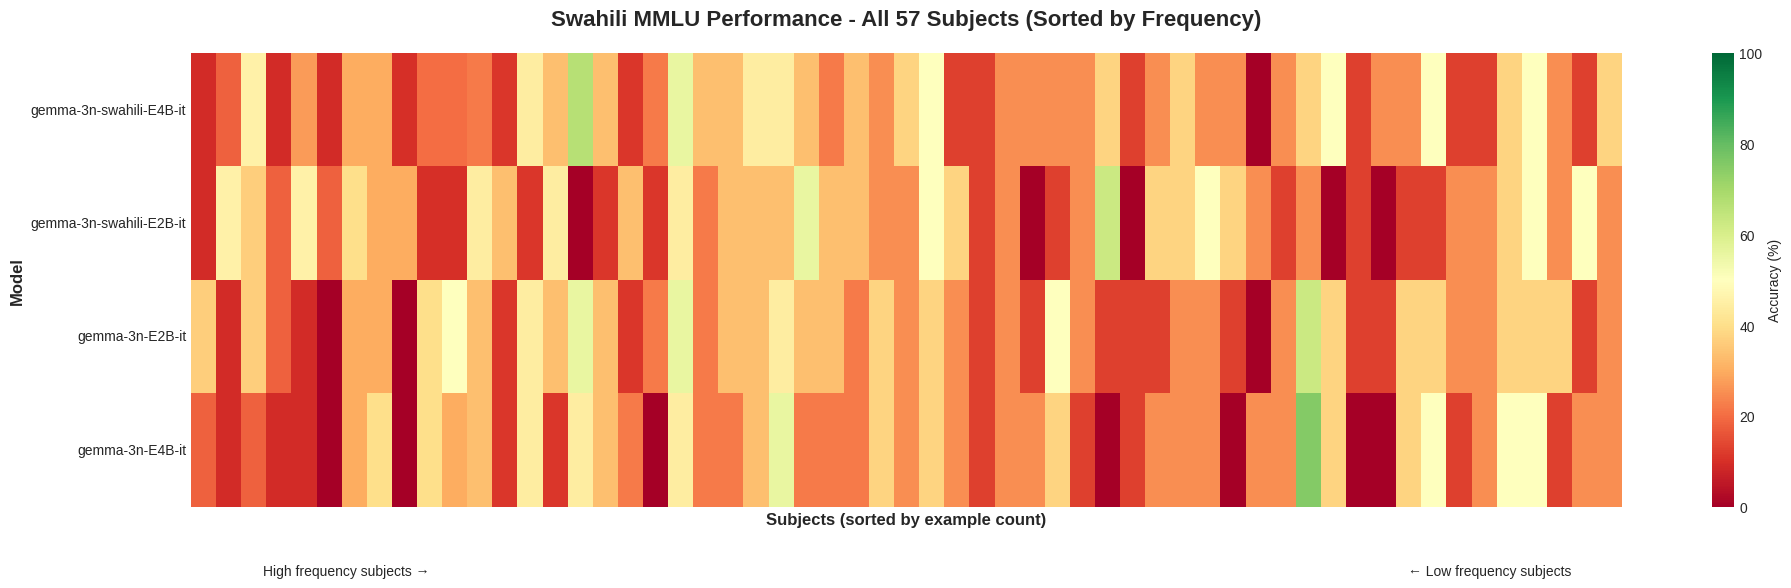

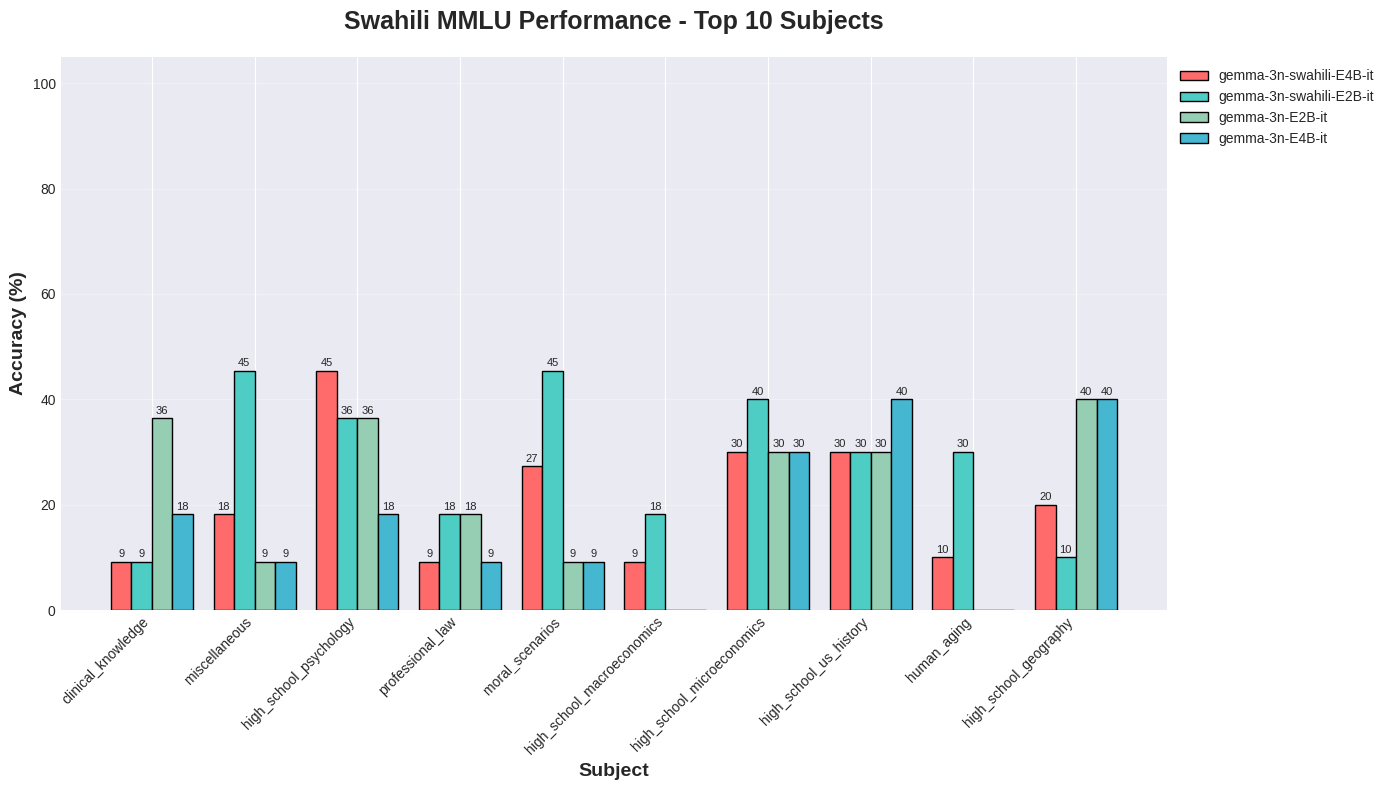

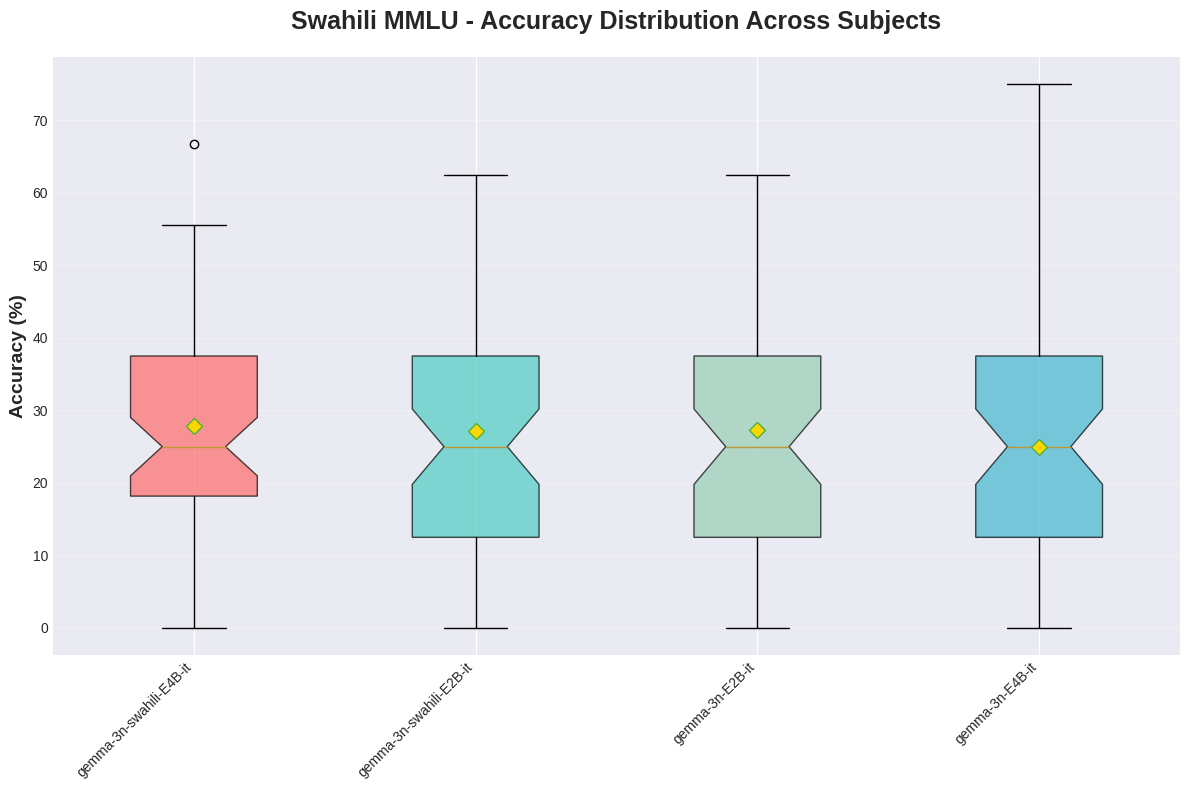

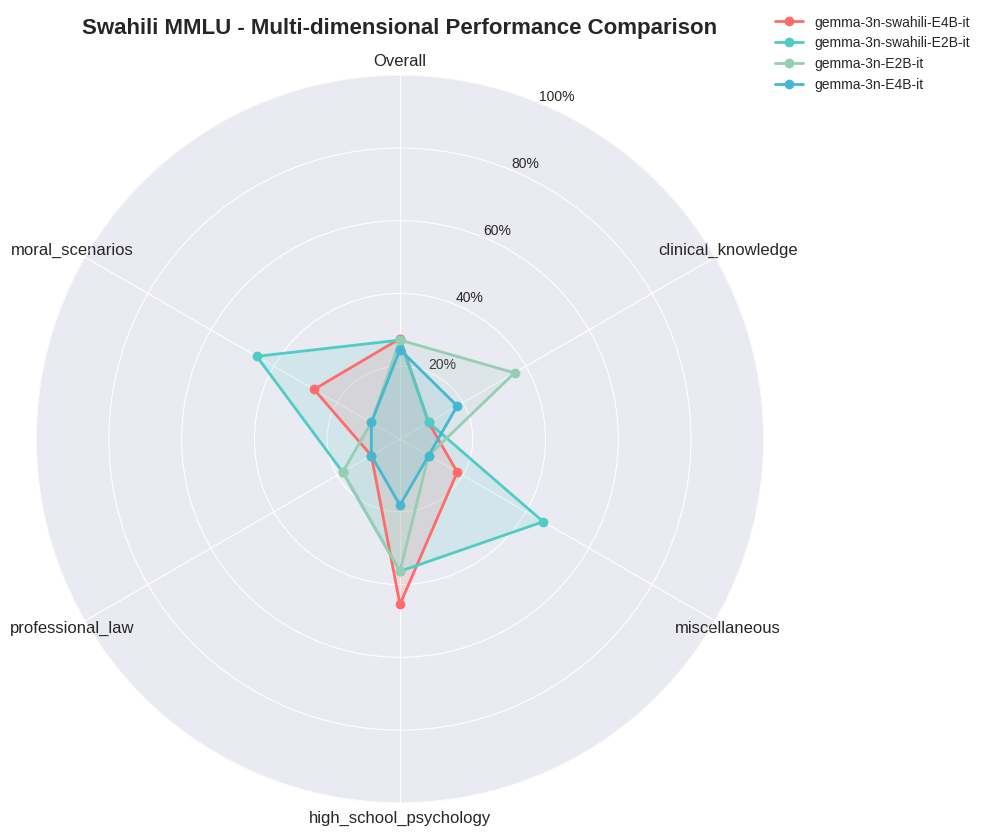


SWAHILI MMLU - SUMMARY STATISTICS
Model                          Overall Acc     Best Subject              Worst Subject            
--------------------------------------------------------------------------------
gemma-3n-swahili-E4B-it          27.6% prehistory           ( 66.7%) college_computer_sci (  0.0%)
gemma-3n-swahili-E2B-it          27.2% jurisprudence        ( 62.5%) college_chemistry    (  0.0%)
gemma-3n-E2B-it                  27.2% high_school_european ( 62.5%) college_computer_sci (  0.0%)
gemma-3n-E4B-it                  24.6% high_school_european ( 75.0%) jurisprudence        (  0.0%)

All visualizations saved to 'plots/' directory
Summary statistics saved to 'results/summary_statistics.json'


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Load results
with open('results/all_models_results.json', 'r', encoding='utf-8') as f:
    all_results = json.load(f)

# Sort models by overall accuracy
sorted_models = sorted(all_results.items(), key=lambda x: x[1]['overall_accuracy'], reverse=True)

# Define distinctive colors for each model
colors = {
    'gemma-3n-swahili-E4B-it': '#FF6B6B',  # Vibrant Red
    'gemma-3n-swahili-E2B-it': '#4ECDC4',  # Turquoise
    'gemma-3n-E4B-it': '#45B7D1',          # Sky Blue
    'gemma-3n-E2B-it': '#96CEB4'           # Mint Green
}

# 1. Overall Performance Bar Chart
plt.figure(figsize=(12, 8))
model_names = [m[0] for m in sorted_models]
accuracies = [m[1]['overall_accuracy'] * 100 for m in sorted_models]

bars = plt.bar(range(len(model_names)), accuracies,
                color=[colors.get(name, '#666666') for name in model_names],
                edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Swahili MMLU (Overall)', fontsize=18, fontweight='bold', pad=20)
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, max(accuracies) * 1.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/overall_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Subject-wise Performance Heatmap (Top 30 subjects by example count)
# Get subject counts and select top 30
subject_counts = {}
for result in all_results.values():
    for subj, count in result['subject_counts'].items():
        subject_counts[subj] = count

# Sort subjects by count and take top 30
top_subjects_for_heatmap = sorted(subject_counts.items(), key=lambda x: x[1], reverse=True)[:30]
top_subject_names = [subj[0] for subj in top_subjects_for_heatmap]

# Create accuracy matrix for top subjects
accuracy_matrix = []
model_names_sorted = [m[0] for m in sorted_models]

for model_name, _ in sorted_models:
    model_accs = []
    for subj in top_subject_names:
        acc = all_results[model_name]['subject_accuracies'].get(subj, 0) * 100
        model_accs.append(acc)
    accuracy_matrix.append(model_accs)

# Create heatmap with better sizing
plt.figure(figsize=(20, 8))
accuracy_matrix_np = np.array(accuracy_matrix)

# Create custom colormap
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Create heatmap without annotations if too many subjects
show_annotations = len(top_subject_names) <= 20

ax = sns.heatmap(accuracy_matrix_np,
                 xticklabels=top_subject_names,
                 yticklabels=model_names_sorted,
                 annot=show_annotations,
                 fmt='.0f',
                 cmap=cmap,
                 cbar_kws={'label': 'Accuracy (%)'},
                 linewidths=0.5,
                 linecolor='gray',
                 square=False,
                 vmin=0,
                 vmax=100,
                 annot_kws={'size': 8})

plt.title('Swahili MMLU Performance by Subject (Top 30 Subjects)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Subject', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/subject_heatmap_top30.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a compact heatmap for all subjects (no labels)
if len(subject_counts) > 30:
    plt.figure(figsize=(20, 6))

    # Get all subjects sorted by count
    all_subjects_sorted = sorted(subject_counts.items(), key=lambda x: x[1], reverse=True)
    all_subject_names = [subj[0] for subj in all_subjects_sorted]

    # Create full accuracy matrix
    full_accuracy_matrix = []
    for model_name, _ in sorted_models:
        model_accs = []
        for subj in all_subject_names:
            acc = all_results[model_name]['subject_accuracies'].get(subj, 0) * 100
            model_accs.append(acc)
        full_accuracy_matrix.append(model_accs)

    full_accuracy_matrix_np = np.array(full_accuracy_matrix)

    # Create compact heatmap
    ax = sns.heatmap(full_accuracy_matrix_np,
                     cmap=cmap,
                     cbar_kws={'label': 'Accuracy (%)'},
                     vmin=0,
                     vmax=100,
                     xticklabels=False,  # No x labels for compact view
                     yticklabels=model_names_sorted)

    plt.title(f'Swahili MMLU Performance - All {len(all_subject_names)} Subjects (Sorted by Frequency)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Subjects (sorted by example count)', fontsize=12, fontweight='bold')
    plt.ylabel('Model', fontsize=12, fontweight='bold')

    # Add text to indicate subject ranges
    ax.text(0.05, -0.15, 'High frequency subjects →', transform=ax.transAxes, fontsize=10)
    ax.text(0.85, -0.15, '← Low frequency subjects', transform=ax.transAxes, fontsize=10)

    plt.tight_layout()
    plt.savefig('plots/subject_heatmap_all_compact.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Subject Performance Comparison (Top Subjects)
# Select top 10 subjects by example count
subject_counts = {}
for result in all_results.values():
    for subj, count in result['subject_counts'].items():
        subject_counts[subj] = count

top_subjects = sorted(subject_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_subj_names = [subj[0] for subj in top_subjects]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_subj_names))
width = 0.2
multiplier = 0

for i, (model_name, _) in enumerate(sorted_models):
    model_accs = []
    for subj in top_subj_names:
        acc = all_results[model_name]['subject_accuracies'].get(subj, 0) * 100
        model_accs.append(acc)

    offset = width * multiplier
    bars = ax.bar(x + offset, model_accs, width,
                   label=model_name,
                   color=colors.get(model_name, '#666666'),
                   edgecolor='black',
                   linewidth=1)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # Only show label if bar is tall enough
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                   f'{height:.0f}', ha='center', va='bottom', fontsize=8)

    multiplier += 1

ax.set_xlabel('Subject', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Swahili MMLU Performance - Top 10 Subjects', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(top_subj_names, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/top_subjects_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Performance Distribution Box Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for box plot
box_data = []
box_labels = []
box_colors_list = []

for model_name, _ in sorted_models:
    subj_accs = list(all_results[model_name]['subject_accuracies'].values())
    subj_accs_percent = [acc * 100 for acc in subj_accs]
    box_data.append(subj_accs_percent)
    box_labels.append(model_name)
    box_colors_list.append(colors.get(model_name, '#666666'))

# Create box plot
bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                notch=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='gold', markersize=8))

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Swahili MMLU - Accuracy Distribution Across Subjects',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xticklabels(box_labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Model Comparison Radar Chart
# Select diverse subjects for radar chart
selected_subjects = ['Overall'] + [subj[0] for subj in top_subjects[:5]]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Number of variables
num_vars = len(selected_subjects)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Plot each model
for model_name, _ in sorted_models:
    values = []

    # Add overall accuracy
    values.append(all_results[model_name]['overall_accuracy'] * 100)

    # Add subject accuracies
    for subj in selected_subjects[1:]:
        acc = all_results[model_name]['subject_accuracies'].get(subj, 0) * 100
        values.append(acc)

    values += values[:1]  # Complete the circle

    ax.plot(angles, values, 'o-', linewidth=2,
            label=model_name, color=colors.get(model_name, '#666666'))
    ax.fill(angles, values, alpha=0.15, color=colors.get(model_name, '#666666'))

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(selected_subjects, fontsize=12)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Swahili MMLU - Multi-dimensional Performance Comparison',
          fontsize=16, fontweight='bold', pad=30)

plt.tight_layout()
plt.savefig('plots/radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Summary Statistics Table
print("\n" + "="*80)
print("SWAHILI MMLU - SUMMARY STATISTICS")
print("="*80)
print(f"{'Model':<30} {'Overall Acc':<15} {'Best Subject':<25} {'Worst Subject':<25}")
print("-"*80)

for model_name, _ in sorted_models:
    result = all_results[model_name]
    overall_acc = result['overall_accuracy'] * 100

    # Find best and worst subjects
    subj_accs = result['subject_accuracies']
    if subj_accs:
        best_subj = max(subj_accs.items(), key=lambda x: x[1])
        worst_subj = min(subj_accs.items(), key=lambda x: x[1])

        print(f"{model_name:<30} {overall_acc:>6.1f}% "
              f"{best_subj[0][:20]:<20} ({best_subj[1]*100:>5.1f}%) "
              f"{worst_subj[0][:20]:<20} ({worst_subj[1]*100:>5.1f}%)")

print("="*80)

# Save summary statistics
summary_stats = {
    'evaluation_summary': {
        'total_models': len(all_results),
        'total_test_examples': list(all_results.values())[0]['total_examples'],
        'total_subjects': len(subjects),
        'evaluation_date': list(all_results.values())[0]['timestamp'].split('T')[0]
    },
    'model_rankings': [
        {
            'rank': i+1,
            'model': model_name,
            'overall_accuracy': result['overall_accuracy'],
            'evaluation_time': result['evaluation_time_seconds']
        }
        for i, (model_name, result) in enumerate(sorted_models)
    ],
    'subject_performance': {
        subj: {
            model: all_results[model]['subject_accuracies'].get(subj, 0)
            for model in all_results
        }
        for subj in subjects
    }
}

with open('results/summary_statistics.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print(f"\nAll visualizations saved to 'plots/' directory")
print(f"Summary statistics saved to 'results/summary_statistics.json'")

In [8]:
!zip -r swahili-mmlu-results.zip /content/results
!zip -r swahili-mmlu-plots.zip /content/plots


  adding: content/results/ (stored 0%)
  adding: content/results/gemma-3n-swahili-E4B-it_results.json (deflated 79%)
  adding: content/results/all_models_results.json (deflated 82%)
  adding: content/results/gemma-3n-swahili-E2B-it_results.json (deflated 80%)
  adding: content/results/gemma-3n-E4B-it_results.json (deflated 79%)
  adding: content/results/gemma-3n-E2B-it_results.json (deflated 80%)
  adding: content/results/summary_statistics.json (deflated 89%)
  adding: content/plots/ (stored 0%)
  adding: content/plots/subject_heatmap_all_compact.png (deflated 31%)
  adding: content/plots/overall_performance.png (deflated 30%)
  adding: content/plots/accuracy_distribution.png (deflated 22%)
  adding: content/plots/top_subjects_comparison.png (deflated 22%)
  adding: content/plots/radar_comparison.png (deflated 8%)
  adding: content/plots/subject_heatmap_top30.png (deflated 21%)
